# Machine learning assignment 4: k-means Cluster Analysis

## Summary
I am using the bike sharing dataset of https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset, which provides data on how many bikes are rent out on specific hours of specific days, the weather on these days, whether the day was a weekday or not, etc. I would like to predict how many bikes are rent out. For this assignment, I am identifying subgroups of weather situations, based on their simularity in temperature, windspeed and humidity. All clustering variables were standardized to have a mean of 0 and a standard deviation of 1. 

Data were randomly split into a training set that included 70% of the observations and a test set that included 30% of the observations. A series of k-means cluster analyses were conducted on the training data specifying k=1-9 clusters, using Euclidean distance. The average distance of observations to their clusters' center was plotted for each of the nine cluster solutions in an elbow curve to provide guidance for choosing the number of clusters to interpret. The elbow curve was inconclusive, suggesting that the 3,4,6-cluster solutions might be interpreted. The results below are for an interpretation of the 3-cluster solution. Canonical discriminant analyses was used to reduce the 3 clustering variable down to a few variables that accounted for most of the variance in the clustering variables. A scatterplot of the first two canonical variables by cluster (see below) indicated that the observations in the clusters are densely packed and do not overlap much. The means of the clustering variables show that cluster 2 has the highest temperature, followed by cluster 1 and 0. Humidity is highest in cluster 1, followed by cluster 2 and 0. Windspeeds are highest in cluster 0, followed by cluster 2 and then cluster 1.

In order to externally validate the clusters, I analyse their association with the annotated weathersituation (weathersit) and the season in which the observation is made (season). Cluster 1 captures the worst weather and is associated mostly with Fall and Spring. Cluster 0 captures better weather and is mostly associated with Winter and Fall. Cluster 2 captures the best weather and is associated mostly with Summer and Spring.
I conducted Chi^2 tests to analyze this associations in more detail. These tests show all pairs of clusters are significantly different in the proportion of seasons for all pairs of seasons and that all pairs of clusters are significantly different in the proportion of assigned weather situations for all pairs of weathersituations.

## Loading data

In [56]:
%matplotlib inline
import numpy
import pandas
from pandas import Series, DataFrame
from sklearn import preprocessing
from sklearn.cluster import KMeans

data = pandas.read_csv('hour.csv', low_memory=False)
print("Number of observations: ", len(data))
data.head()

Number of observations:  17379


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Managing data
Selecting relevant variables

In [57]:
seasmap = {1: '1. Winter', 2:'2. Spring', 3:'3. Summer', 4:'4. Fall'}
data['season'] = data['season'].map(seasmap)
selected_vars = ['temp','hum','windspeed']
cluster = data[selected_vars].copy()

### Standardize variables to have mean = 0 and sd = 1

In [58]:
for i in selected_vars:
    cluster[i] = preprocessing.scale(cluster[i].astype('float64'))

## Learning the model

In [59]:
from sklearn.cross_validation import train_test_split
clus_train, clus_test = train_test_split(cluster, test_size=.3, random_state=123)

In [60]:
from scipy.spatial.distance import cdist
clusters=range(1,10)
meandist=[]

for k in clusters:
    model=KMeans(n_clusters=k,random_state=123)
    model.fit(clus_train)
    clusassign=model.predict(clus_train)
    meandist.append(numpy.mean(numpy.min(cdist(clus_train, model.cluster_centers_, 'euclidean'), axis=1)))

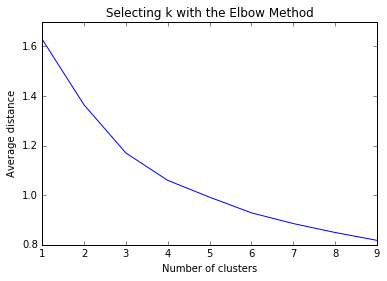

In [61]:
import matplotlib.pylab as plt
plt.plot(clusters, meandist)
plt.xlabel('Number of clusters')
plt.ylabel('Average distance')
plt.title('Selecting k with the Elbow Method');

In [62]:
model3=KMeans(n_clusters=3,random_state=123)
model3.fit(clus_train)
clusassign=model3.predict(clus_train)

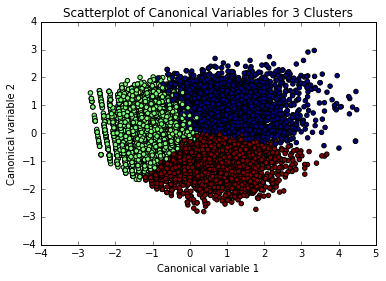

In [63]:
from sklearn.decomposition import PCA
pca_2 = PCA(2)
plot_columns = pca_2.fit_transform(clus_train)
plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=model3.labels_,)
plt.xlabel('Canonical variable 1')
plt.ylabel('Canonical variable 2')
plt.title('Scatterplot of Canonical Variables for 3 Clusters')
plt.show()

In [64]:
clus_train.reset_index(level=0, inplace=True)

In [65]:
cluslist=list(clus_train['index'])
labels=list(model3.labels_)
newlist=dict(zip(cluslist, labels))
newclus=DataFrame.from_dict(newlist, orient='index')
newclus.columns = ['cluster']
newclus.head()

,cluster
0,1
1,1
2,1
3,1
4,1


In [66]:
newclus.reset_index(level=0, inplace=True)

In [67]:
merged_train=pandas.merge(clus_train, newclus, on='index')
merged_train.head(n=20)

,index,temp,hum,windspeed,cluster
0,1859,-0.815304,1.258375,0.519896,1
1,7302,-0.919172,0.169865,-1.553889,1
2,17094,-0.919172,0.169865,-1.553889,1
3,17009,-0.607566,0.999206,0.031899,1
4,1636,-0.295959,-1.125980,1.374096,0
5,7831,-0.088222,0.480868,0.519896,1
6,11537,0.119516,-0.400306,-0.211691,2
7,12655,0.950466,-1.125980,-0.699689,2
8,2693,0.431122,1.310209,0.764304,1
9,10435,0.119516,0.273533,-0.456099,1


In [68]:
merged_train.cluster.value_counts()

1    5015
2    3693
0    3457
Name: cluster, dtype: int64

In [69]:
clustergrp = merged_train.groupby('cluster').mean()
print ("Clustering variable means by cluster")
print(clustergrp)

Clustering variable means by cluster
               index      temp       hum  windspeed
cluster                                            
0        7835.767139 -0.830597 -0.730741   0.734541
1        8884.408574 -0.229765  0.864170  -0.555435
2        9193.337395  1.075176 -0.505027   0.070091


## Validate by weathersituation
The dataset contains a variable weathersit which is a label for the weather situation at that observation. Values for this label are:
 * 1: Clear, Few clouds, Partly cloudy, Partly cloudy
 * 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
 * 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
 * 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
 
I would like to see if this weathersituation is captured by the clustering of the weather variables.

In [70]:
ws_data=data[['weathersit']]
# split ws data into train and test sets
ws_train, ws_test = train_test_split(ws_data, test_size=.3, random_state=123)
ws_train1=pandas.DataFrame(ws_train)
ws_train1.reset_index(level=0, inplace=True)
merged_train_all=pandas.merge(ws_train1, merged_train, on='index')
sub1 = merged_train_all[['weathersit','cluster']].dropna()

In [71]:
pandas.crosstab(sub1.weathersit, sub1.cluster)

cluster,0,1,2
weathersit,,,
1,2543,2521,2924
2,761,1758,668
3,153,735,101
4,0,1,0


Since weathersituation 4 only occurs once in the training data, I merge it with weather situation 3.

In [72]:
sub1['weathersit'] = sub1['weathersit'].map({1:1,2:2,3:3,4:3})

The cross table then looks as follows:

In [73]:
ct = pandas.crosstab(sub1.weathersit, sub1.cluster)
print(ct)
colsum=ct.sum(axis=0)
colpct=ct/colsum
print(colpct)

cluster        0     1     2
weathersit                  
1           2543  2521  2924
2            761  1758   668
3            153   736   101
cluster            0         1         2
weathersit                              
1           0.735609  0.502692  0.791768
2           0.220133  0.350548  0.180883
3           0.044258  0.146760  0.027349


It looks like the clusters are associated with weathersituation, with cluster 1 capturing the worst weather, cluster 0 capturing better weather and cluster 2 capturing the 'best' weather. I conduct a Chi^2 test to examine this closer.

In [74]:
import scipy.stats
print ('chi-square value, p value, expected counts')
scipy.stats.chi2_contingency(ct)

chi-square value, p value, expected counts


(1036.9358733542258,
 3.5301633674731902e-223,
 4,
 array([[ 2269.9972051 ,  3293.03904644,  2424.96374846],
        [  905.66863954,  1313.8351829 ,   967.49617756],
        [  281.33415536,   408.12577065,   300.54007398]]))

The Chi-square test shows that weather situation is associated with the cluster. Post hoc tests are required to show how exactly.

In [75]:
numcomparisons = 0
table = pandas.DataFrame('-',index=range(0,3),columns=range(0,3))
for i in range(0,3):
    for j in range(i+1,3):
        sub2 = sub1[(sub1['cluster'] == i) | (sub1['cluster'] == j)]
        ct = pandas.crosstab(sub2.weathersit, sub2.cluster)    
        chi2, p, dof, ex = scipy.stats.chi2_contingency(ct)
        numcomparisons = numcomparisons+1
        table.iloc[j,i] = p

print("number of comparisons ",numcomparisons)
pcritical = 0.05/numcomparisons
print("Bonferroni corrected critical p: ",pcritical)
table

number of comparisons  3
Bonferroni corrected critical p:  0.016666666666666666


,0,1,2
0,-,-,-
1,5.73473e-111,-,-
2,1.95615e-08,1.115e-178,-


The post-hoc test shows that all pairs of clusters are significantly different in the proportion of assigned weather situations. Another posthoc test is required to show how exactly.

In [76]:
numcomparisons = 0
colnames = []
rownames = []
table = pandas.DataFrame('-',index=range(0,3),columns=range(0,3))
for cl1 in range(0,3):
    for cl2 in range(cl1+1,3):
        colnames.append("cluster "+str(cl1)+" vs "+str(cl2))
        for ws1 in range(0,3):
            for ws2 in range(ws1+1,3):
                rownames.append("weathersit "+str(ws1)+","+str(ws2))
                sub2 = sub1[(sub1['cluster'] == cl1) | (sub1['cluster'] == cl2)|(sub1['weathersit'] == ws1) | (sub1['weathersit'] == ws2)]
                ct = pandas.crosstab(sub2.weathersit, sub2.cluster)    
                chi2, p, dof, ex = scipy.stats.chi2_contingency(ct)
                numcomparisons = numcomparisons+1                
                table.iloc[cl1+cl2-1,ws1+ws2-1] = p

print("number of comparisons ",numcomparisons)
pcritical = 0.05/numcomparisons
print("Bonferroni corrected critical p: ",pcritical)
table.columns = colnames
table.index = rownames[0:3]
table

number of comparisons  9
Bonferroni corrected critical p:  0.005555555555555556


,cluster 0 vs 1,cluster 0 vs 2,cluster 1 vs 2
"weathersit 0,1",0,0,1.45639e-272
"weathersit 0,2",6.82231e-164,0,1.91459e-158
"weathersit 1,2",0,0,2.22136e-290


The final posthoc test shows that all pairs of clusters are significantly different in the proportion of assigned weather situations for all pairs of weathersituations.

## Validate by season

In [78]:
ws_data=data[['season']]
# split ws data into train and test sets
ws_train, ws_test = train_test_split(ws_data, test_size=.3, random_state=123)
ws_train1=pandas.DataFrame(ws_train)
ws_train1.reset_index(level=0, inplace=True)
merged_train_all=pandas.merge(ws_train1, merged_train, on='index')
sub1 = merged_train_all[['season','cluster']].dropna()

In [79]:
ct = pandas.crosstab(sub1.season, sub1.cluster)
print(ct)
colsum=ct.sum(axis=0)
colpct=ct/colsum
print(colpct)

cluster       0     1     2
season                     
1. Winter  1844  1101    87
2. Spring   638  1277  1156
3. Summer    34  1012  2099
4. Fall     941  1625   351
cluster           0         1         2
season                                 
1. Winter  0.533410  0.219541  0.023558
2. Spring  0.184553  0.254636  0.313025
3. Summer  0.009835  0.201795  0.568373
4. Fall    0.272201  0.324028  0.095045


Cluster 1 seems to be mostly assigned to Fall and Spring, cluster 0 to Winter and Fall, cluster 2 to Summer and Spring. I conduct a Chi^2 test to examine this closer.

In [80]:
import scipy.stats
print ('chi-square value, p value, expected counts')
scipy.stats.chi2_contingency(ct)

chi-square value, p value, expected counts


(4756.444683243044,
 0.0,
 6,
 array([[  861.62137279,  1249.93670366,   920.44192355],
        [  872.70423346,  1266.01438553,   932.28138101],
        [  893.73325113,  1296.52075627,   954.7459926 ],
        [  828.94114262,  1202.52815454,   885.53070284]]))

The Chi-square test shows that season is associated with the cluster. Post hoc tests are required to show how exactly.

In [81]:
numcomparisons = 0
table = pandas.DataFrame('-',index=range(0,3),columns=range(0,3))
for i in range(0,3):
    for j in range(i+1,3):
        sub2 = sub1[(sub1['cluster'] == i) | (sub1['cluster'] == j)]
        ct = pandas.crosstab(sub2.season, sub2.cluster)    
        chi2, p, dof, ex = scipy.stats.chi2_contingency(ct)
        numcomparisons = numcomparisons+1
        table.iloc[j,i] = p

print("number of comparisons ",numcomparisons)
pcritical = 0.05/numcomparisons
print("Bonferroni corrected critical p: ",pcritical)
table

number of comparisons  3
Bonferroni corrected critical p:  0.016666666666666666


,0,1,2
0,-,-,-
1,2.00405e-271,-,-
2,0,0,-


The post-hoc test shows that all pairs of clusters are significantly different in the proportion of seasons. Another posthoc test is required to show how exactly.

In [82]:
numcomparisons = 0
colnames = []
rownames = []
table = pandas.DataFrame('-',index=range(0,6),columns=range(0,3))
for cl1 in range(0,3):
    for cl2 in range(cl1+1,3):
        colnames.append("cluster "+str(cl1)+" vs "+str(cl2))
        i = 0
        for s1 in range(0,4):
            for s2 in range(s1+1,4):
                rownames.append(seasmap[s1+1]+","+seasmap[s2+1])
                sub2 = sub1[(sub1['cluster'] == cl1) | (sub1['cluster'] == cl2)|(sub1['season'] == seasmap[s1+1]) | (sub1['season'] == seasmap[s2+1])]
                ct = pandas.crosstab(sub2.season, sub2.cluster)    
                chi2, p, dof, ex = scipy.stats.chi2_contingency(ct)
                numcomparisons = numcomparisons+1                                
                table.iloc[i,cl1+cl2-1] = p
                i = i+1

print("number of comparisons ",numcomparisons)
pcritical = 0.05/numcomparisons
print("Bonferroni corrected critical p: ",pcritical)
table.columns = colnames
table.index = rownames[0:6]
table

number of comparisons  18
Bonferroni corrected critical p:  0.002777777777777778


,cluster 0 vs 1,cluster 0 vs 2,cluster 1 vs 2
"1. Winter,2. Spring",0,0,0
"1. Winter,3. Summer",0,0,0
"1. Winter,4. Fall",0,0,0
"2. Spring,3. Summer",0,0,0
"2. Spring,4. Fall",0,0,0
"3. Summer,4. Fall",0,0,0


The final posthoc test shows that all pairs of clusters are significantly different in the proportion of seasons for all pairs of seasons.